#Import des différentes librairies

In [ ]:
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import requests
import io
import time
import datetime
from collections import Counter
import seaborn as sns
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, MDS
from sklearn.cluster import AgglomerativeClustering
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, AdaBoostClassifier
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, classification_report
from imblearn.over_sampling import SMOTE

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


#Récupération des jeux de données

In [ ]:
def load_dataset(csv_url):
  return pd.read_csv(csv_url)

#general_data = load_dataset("https://raw.githubusercontent.com/NicolasDrapier/ProjetIA/main/general_data.csv")
#employee_survey_data = load_dataset("https://raw.githubusercontent.com/NicolasDrapier/ProjetIA/main/employee_survey_data.csv")
#manager_survey_data = load_dataset("https://raw.githubusercontent.com/NicolasDrapier/ProjetIA/main/manager_survey_data.csv")
data = load_dataset("https://raw.githubusercontent.com/NicolasDrapier/ProjetIA/main/mix_encoded.csv")

#Jointures des jeux de données

In [ ]:
#data = pd.merge(general_data, employee_survey_data, on='EmployeeID')
#data = pd.merge(data, manager_survey_data, on='EmployeeID')
#data.set_index('EmployeeID', inplace=True)

#Exploration

In [ ]:
data.head()

,EmployeeID,Age,Attrition,BusinessTravel,DistanceFromHome,Education,Gender,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,MeanTimeAtWorkByYear
0,1,51,0,2,6,2,0,1,131160,1.0,11,0,1.0,6,1,0,0,3.0,4.0,2.0,3,3,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,7.373651
1,2,31,1,1,10,1,0,1,41890,0.0,23,1,6.0,3,5,1,4,3.0,2.0,4.0,2,4,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,7.718969
2,3,32,0,1,17,4,1,4,193280,1.0,15,3,5.0,2,5,0,3,2.0,2.0,1.0,3,3,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,7.013240
3,4,38,0,0,2,5,1,3,83210,3.0,11,3,13.0,5,8,7,5,4.0,4.0,3.0,2,3,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,7.193678
4,5,32,0,2,10,1,1,1,23420,4.0,12,2,9.0,2,6,0,4,4.0,1.0,3.0,3,3,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,8.006175


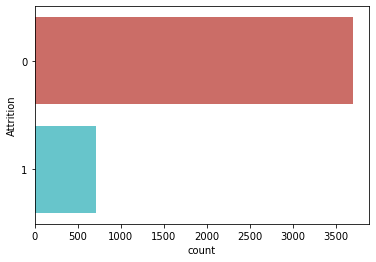

In [ ]:
sns.countplot(y=data['Attrition'], data=data, palette='hls')
plt.show()

On peut voir que notre jeu de données est déséquilibré

In [ ]:
#Matrice de corrélation
#numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
#size = (12,8)
#fact = 10
#scatt = scatter_matrix(data.select_dtypes(include=numerics), figsize=([fact*x for x in size]))
#plt.savefig('./correlation.png')
#plt.show()

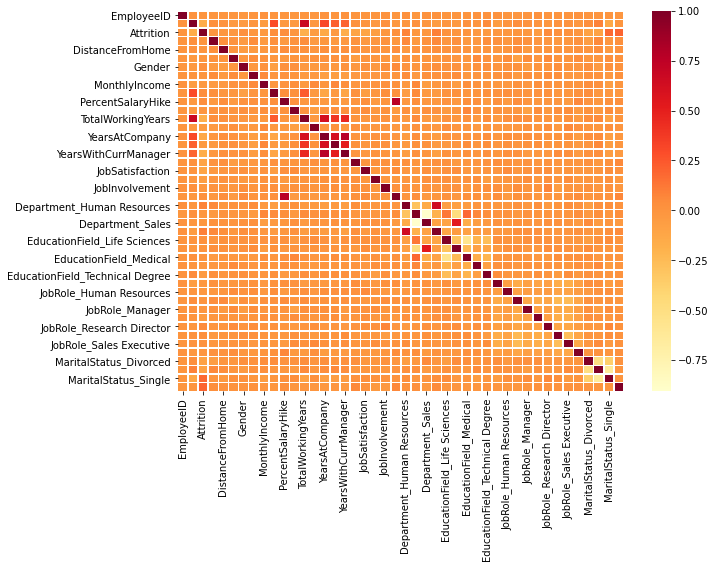

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))

sns.heatmap(data.corr(),cmap='YlOrRd',linewidths=.5,ax=ax)

#Preprocessing

In [ ]:
def scale(s):
  _std_scale = StandardScaler()
  _scaled = _std_scale.fit_transform(s)
  return _scaled

In [ ]:
cop = data.copy()
y = cop['Attrition']
x = cop.drop(['Attrition', 'EmployeeID'], axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
print(x_train.shape, y_train.shape)

(3528, 42) (3528,)


In [ ]:
x_train.head()

,Age,BusinessTravel,DistanceFromHome,Education,Gender,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,MeanTimeAtWorkByYear
2588,38,2,3,4,0,1,44900,2.0,21,1,10.0,1,5,0,3,2.0,4.0,4.0,3,4,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,7.615880
2354,45,2,29,2,0,2,29730,1.0,12,0,10.0,2,10,1,4,3.0,1.0,3.0,3,3,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,8.907959
655,45,2,12,3,1,2,43060,2.0,11,2,26.0,3,24,1,11,1.0,2.0,3.0,3,3,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,9.878690
4339,55,2,6,1,0,2,26550,8.0,17,0,36.0,0,24,2,15,3.0,2.0,3.0,2,3,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,6.076174
3557,44,2,3,4,1,2,25640,1.0,12,3,20.0,3,20,13,17,4.0,4.0,3.0,1,3,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,7.606718


In [ ]:
x_train.shape

(3528, 42)

In [ ]:
smote = SMOTE(random_state=42)
smote_data_x, smote_data_y = smote.fit_sample(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
print('Original data', len(x_train))
print("Nombre de ceux qui restent avant sampling",y_train.tolist().count(0))
print("Nombre de ceux qui partent avant sampling",y_train.tolist().count(1))
print('--------------------')
print('Oversampling', len(smote_data_x))
print("Nombre de ceux qui restent après sampling",smote_data_y.tolist().count(0))
print("Nombre de ceux qui partent après sampling",smote_data_y.tolist().count(1))

Original data 3528
Nombre de ceux qui restent avant sampling 2958
Nombre de ceux qui partent avant sampling 570
--------------------
Oversampling 5916
Nombre de ceux qui restent après sampling 2958
Nombre de ceux qui partent après sampling 2958


In [ ]:
smote_data_x.shape

(5916, 42)

In [ ]:
x_train_scaled = scale(smote_data_x)
x_test_scaled = scale(x_test)

In [ ]:
x_train_scaled.shape

(5916, 42)

# Test d'indépendance avec le test du chi-square :
## Hypothèses :

* Hypothèse nulle (H0)

    * H0  :  Il n'y a pas de relation entre 2 variables

* Hypothèse alternative (H1)

  * H1   :  Il y a une relation entre 2 variables

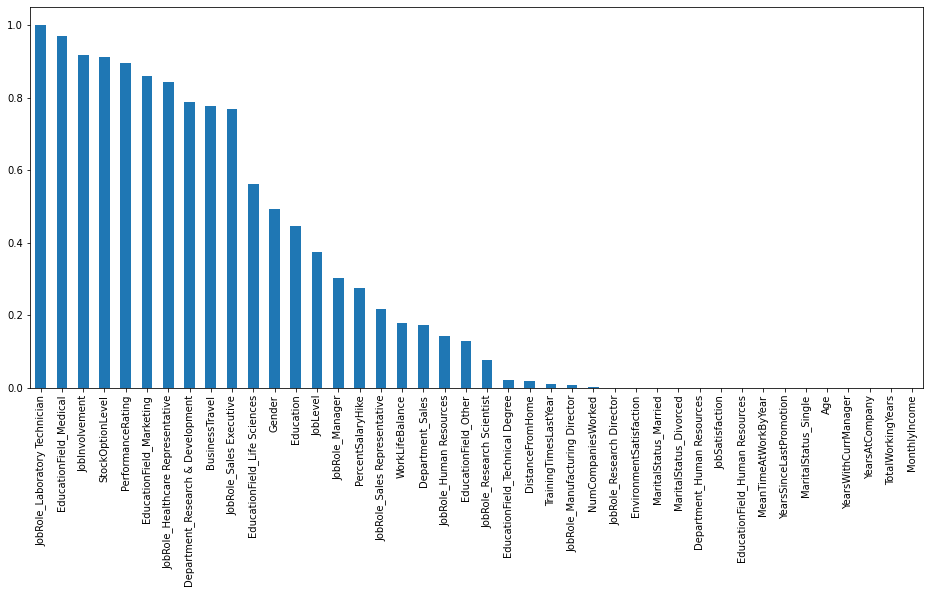

In [ ]:
plt.figure(figsize=(16,7))
chi_scores = chi2(x_train, y_train)
p_values = pd.Series(chi_scores[1],index = x_train.columns)
p_values.sort_values(ascending = False , inplace = True)
p_values.plot.bar()

  Les variables ayant les p-value les plus élevées sont donc indépendantes des autres et ne peuvent pas être utilisée dans le modèle de données. Ce sont les variables supprimées par la PCA

#PCA

In [ ]:
pca = PCA(0.95, random_state=42)
pca.fit(x_train_scaled)
pca.n_components_

32

In [ ]:
x_train_scaled = pca.transform(x_train_scaled)
x_test_scaled = pca.transform(x_test_scaled)

In [ ]:
n_pcs = pca.components_.shape[0]
f = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]
mf = [x_train.columns[f[i]] for i in range(n_pcs)]

print("Top features de la PCA:")
for i, m in enumerate(mf):
  print(i+1, ':', m)

Top features de la PCA:
1 : YearsAtCompany
2 : Department_Research & Development
3 : Department_Human Resources
4 : PerformanceRating
5 : MaritalStatus_Married
6 : EducationField_Life Sciences
7 : NumCompaniesWorked
8 : JobRole_Research Scientist
9 : MaritalStatus_Divorced
10 : Education
11 : JobRole_Research Director
12 : DistanceFromHome
13 : JobRole_Manager
14 : JobRole_Healthcare Representative
15 : JobRole_Manufacturing Director
16 : JobRole_Human Resources
17 : JobRole_Healthcare Representative
18 : JobRole_Sales Representative
19 : JobInvolvement
20 : BusinessTravel
21 : DistanceFromHome
22 : EnvironmentSatisfaction
23 : EnvironmentSatisfaction
24 : JobLevel
25 : WorkLifeBalance
26 : MonthlyIncome
27 : MeanTimeAtWorkByYear
28 : Education
29 : MeanTimeAtWorkByYear
30 : TrainingTimesLastYear
31 : DistanceFromHome
32 : EducationField_Marketing


#t-SNE

In [ ]:
x_tsne = scale(smote_data_x)
tsne = TSNE(n_components=2, verbose=2, random_state=42, init='pca')
h = tsne.fit_transform(x_tsne)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5916 samples in 0.057s...
[t-SNE] Computed neighbors for 5916 samples in 3.197s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5916
[t-SNE] Computed conditional probabilities for sample 2000 / 5916
[t-SNE] Computed conditional probabilities for sample 3000 / 5916
[t-SNE] Computed conditional probabilities for sample 4000 / 5916
[t-SNE] Computed conditional probabilities for sample 5000 / 5916
[t-SNE] Computed conditional probabilities for sample 5916 / 5916
[t-SNE] Mean sigma: 2.892345
[t-SNE] Computed conditional probabilities in 0.345s
[t-SNE] Iteration 50: error = 88.3178024, gradient norm = 0.0013114 (50 iterations in 3.001s)
[t-SNE] Iteration 100: error = 88.2261734, gradient norm = 0.0009543 (50 iterations in 2.886s)
[t-SNE] Iteration 150: error = 88.1240311, gradient norm = 0.0007089 (50 iterations in 2.865s)
[t-SNE] Iteration 200: error = 88.0787048, gradient norm = 0.0005383 (50 iterations in 2.670s)
[t

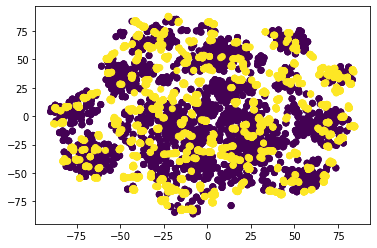

In [ ]:
a, b = h[:,0], h[:,1]
plt.scatter(a,b,c=smote_data_y)

#Modèles de machine learning

##Régression logistique

In [ ]:
logistic_model = LogisticRegression(penalty='l2', C=0.001, solver='newton-cg', random_state=42, verbose=2)

##Stochastic Gradient Descent

In [ ]:
sgd = SGDClassifier(random_state=42)

##Perceptron

In [ ]:
#perceptron = Perceptron(random_state=42)


#grid={
#    'penalty':['l1', 'l2', 'elasticnet'],
#    'alpha': [0.1, 0.01, 0.001, 0.0001],
#    'fit_intercept': [True, False],
#    'max_iter': [300, 500, 750, 1000, 1500],
#    'shuffle': [True, False]
#  }

#gcv = GridSearchCV(Perceptron(random_state=42), param_grid=grid, n_jobs=-1, cv=3)
#gcv.fit(x_train_scaled, smote_data_y)
#print('Best parameters found:\n', gcv.best_params_)

In [ ]:
perceptron = Perceptron(random_state=42, alpha=0.001, fit_intercept=True, max_iter=300, shuffle=True, penalty='l1')

##Random Forest

In [ ]:
forest_clf = RandomForestClassifier(random_state=42)

##Multi Layer Perceptron

In [ ]:
#start = time.time()
#grid = {
#    'hidden_layer_sizes': [100, 150, 200, 250],
#    'activation': ['identity', 'logistic', 'tanh', 'relu'],
#    'solver': ['adam', 'sgd', 'lbfgs'],
#    'batch_size' : ['auto', 256, 350, 500, 100, 64],
#    'learning_rate': ['constant', 'invscaling', 'adaptive'],
#    'max_iter': [200, 300, 500, 1000],
#    'shuffle': [True, False],
#    'warm_start' : [True, False],
#    'momentum': [0.5, 0.7, 0.9, 0.2],
#    'n_iter_no_change' : [5, 10, 15, 20]

#}
#gcv = GridSearchCV(MLPClassifier(random_state=42), param_grid=grid, n_jobs=-1, cv=3)
#gcv.fit(x_train_scaled, smote_data_y)

#end = time.time()
#total = end-start
#print(str(datetime.timedelta(seconds=total)))
#print('Best parameters found:\n', gcv.best_params_)

mlp = MLPClassifier(random_state=42, max_iter=350)

##SVM

In [ ]:
#grid = {
#    'kernel': ['poly', 'linear', 'rbf', 'sigmoid'],
#    'C': [1.0, 0.5, 1.5],
#    'degree': [3, 4, 5],
#    'gamma': ['auto', 'scale'],
#    'probability': [True, False],
#    'decision_function_shape': ['ovo', 'ovr']
#}
#gcv = GridSearchCV(SVC(random_state=42), param_grid=grid, n_jobs=-1, cv=3)
#gcv.fit(x_train_scaled, smote_data_y)
#print('Best parameters found:\n', gcv.best_params_)

In [ ]:
svc = SVC(random_state=42, kernel='poly', probability=True, degree=4, decision_function_shape='ovo', C=1.9, gamma='auto')

#Prédictions

Matrice de confusion parfaite

In [ ]:
confusion_matrix(smote_data_y, smote_data_y)

array([[2958,    0],
       [   0, 2958]])

##Matrice de confusion de régression logistique

In [ ]:
y_predictions_log = cross_val_predict(logistic_model, x_train_scaled, smote_data_y, cv=5, method='predict_proba')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

In [ ]:
y_predictions_log_cm = [np.argmax(x) for x in y_predictions_log]
y_predictions_log = y_predictions_log[:,1]

In [ ]:
cm = confusion_matrix(smote_data_y, y_predictions_log_cm)
cm

array([[2181,  777],
       [ 713, 2245]])

In [ ]:
print(accuracy_score(smote_data_y, y_predictions_log_cm))
print(classification_report(smote_data_y, y_predictions_log_cm))

0.7481406355645707
              precision    recall  f1-score   support

           0       0.75      0.74      0.75      2958
           1       0.74      0.76      0.75      2958

    accuracy                           0.75      5916
   macro avg       0.75      0.75      0.75      5916
weighted avg       0.75      0.75      0.75      5916



##Matrice de confusion du SGD

In [ ]:
clf_isotonic = CalibratedClassifierCV(sgd, cv=10, method='isotonic')
y_predictions_sgd = cross_val_predict(clf_isotonic, x_train_scaled, smote_data_y, cv=5, method='predict_proba')
y_predictions_sgd_cm = [np.argmax(x) for x in y_predictions_sgd]
y_predictions_sgd = y_predictions_sgd[:,1]
cm = confusion_matrix(smote_data_y, y_predictions_sgd_cm)
print(cm)

[[2211  747]
 [ 748 2210]]


In [ ]:
print(accuracy_score(smote_data_y, y_predictions_sgd_cm))
print(classification_report(smote_data_y, y_predictions_sgd_cm))

0.7472954699121027
              precision    recall  f1-score   support

           0       0.75      0.75      0.75      2958
           1       0.75      0.75      0.75      2958

    accuracy                           0.75      5916
   macro avg       0.75      0.75      0.75      5916
weighted avg       0.75      0.75      0.75      5916



##Matrice de confusion du perceptron

In [ ]:
clf_isotonic = CalibratedClassifierCV(perceptron, cv=10, method='isotonic')
y_predictions_percept = cross_val_predict(clf_isotonic, x_train_scaled, smote_data_y, cv=5, method="predict_proba")

In [ ]:
y_predictions_percept_cm = [np.argmax(x) for x in y_predictions_percept]
y_predictions_percept = y_predictions_percept[:,1]
cm = confusion_matrix(smote_data_y, y_predictions_percept_cm)
cm

array([[2202,  756],
       [ 760, 2198]])

In [ ]:
print(accuracy_score(smote_data_y, y_predictions_percept_cm))
print(classification_report(smote_data_y, y_predictions_percept_cm))

0.7437457741717377
              precision    recall  f1-score   support

           0       0.74      0.74      0.74      2958
           1       0.74      0.74      0.74      2958

    accuracy                           0.74      5916
   macro avg       0.74      0.74      0.74      5916
weighted avg       0.74      0.74      0.74      5916



##Matrice de confusion du MLP

In [ ]:
y_predictions_mlpercept = cross_val_predict(mlp, x_train_scaled, smote_data_y, cv=5, method='predict_proba')
y_predictions_mlpercept_cm = [np.argmax(x) for x in y_predictions_mlpercept]
y_predictions_mlpercept = y_predictions_mlpercept[:,1]

In [ ]:
cm = confusion_matrix(smote_data_y, y_predictions_mlpercept_cm)
cm

array([[2913,   45],
       [  12, 2946]])

In [ ]:
print(accuracy_score(smote_data_y, y_predictions_mlpercept_cm))
print(classification_report(smote_data_y, y_predictions_mlpercept_cm))

0.9903651115618661
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      2958
           1       0.98      1.00      0.99      2958

    accuracy                           0.99      5916
   macro avg       0.99      0.99      0.99      5916
weighted avg       0.99      0.99      0.99      5916



##Matrice de confusion de Random Forest

In [ ]:
ada = AdaBoostClassifier(forest_clf, n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(ada, x_train_scaled, smote_data_y, cv=3,method='predict_proba')
y_predict_forest = [np.argmax(x) for x in y_probas_forest]

In [ ]:
cm = confusion_matrix(smote_data_y, y_predict_forest)
cm

array([[2925,   33],
       [  76, 2882]])

In [ ]:
print(accuracy_score(smote_data_y, y_predict_forest))
print(classification_report(smote_data_y, y_predict_forest))

0.9815753887762001
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2958
           1       0.99      0.97      0.98      2958

    accuracy                           0.98      5916
   macro avg       0.98      0.98      0.98      5916
weighted avg       0.98      0.98      0.98      5916



## Matrice de confusion du SVM

In [ ]:
y_predictions_svc = cross_val_predict(svc, x_train_scaled, smote_data_y, cv=5, method='predict_proba')
y_predictions_svc_cm = [np.argmax(x) for x in y_predictions_svc]
y_predictions_svc = y_predictions_svc[:,1]

In [ ]:
cm = confusion_matrix(smote_data_y, y_predictions_svc_cm)
cm

array([[2948,   10],
       [   9, 2949]])

In [ ]:
print(accuracy_score(smote_data_y, y_predictions_svc_cm))
print(classification_report(smote_data_y, y_predictions_svc_cm))

0.9967883705206221
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2958
           1       1.00      1.00      1.00      2958

    accuracy                           1.00      5916
   macro avg       1.00      1.00      1.00      5916
weighted avg       1.00      1.00      1.00      5916



#Courbe ROC

Rappel des formules: 

_recall_, soit de celle du _TPR_ :
$$
TPR = \frac{TP}{TP+FN}
$$
_FPR_ :
$$
FPR = \frac{FP}{TN+FP}
$$

In [ ]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

Courbe ROC de la régression logistique

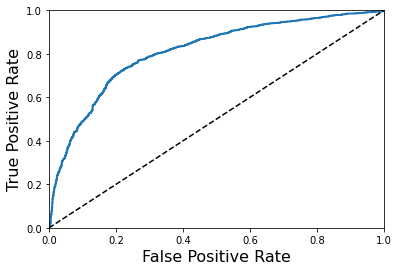

In [ ]:
fpr_log, tpr_log, thresholds_log = roc_curve(smote_data_y, y_predictions_log)
plot_roc_curve(fpr_log, tpr_log)

Courbe ROC du SGD

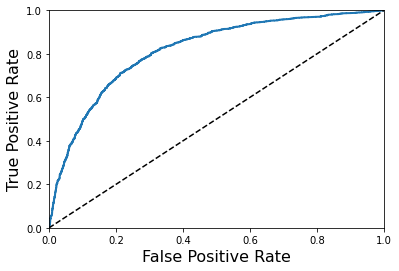

In [ ]:
fpr_sgd, tpr_sgd, thresholds_sgd = roc_curve(smote_data_y, y_predictions_sgd)
plot_roc_curve(fpr_sgd, tpr_sgd)

Courbe ROC du perceptron

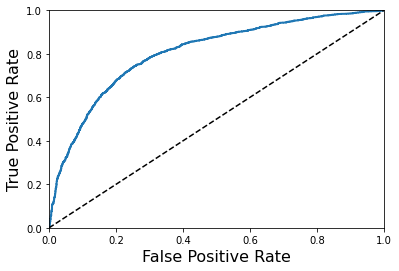

In [ ]:
fpr_percept, tpr_percept, thresholds_percept = roc_curve(smote_data_y, y_predictions_percept)
plot_roc_curve(fpr_percept, tpr_percept)

Courbe ROC du MLP

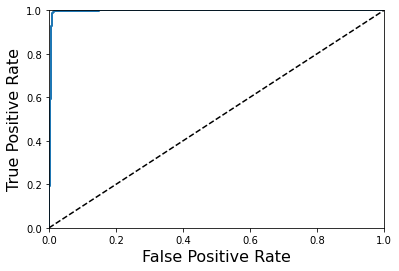

In [ ]:
fpr_mlpercept, tpr_mlpercept, thresholds_mlpercept = roc_curve(smote_data_y, y_predictions_mlpercept)
plot_roc_curve(fpr_mlpercept, tpr_mlpercept)

Courbe ROC du SVM

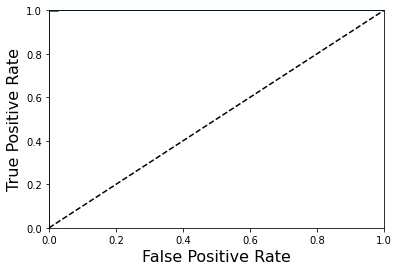

In [ ]:
fpr_svc, tpr_svc, thresholds_svc = roc_curve(smote_data_y, y_predictions_svc)
plot_roc_curve(fpr_svc, tpr_svc)

Aggrégat

In [ ]:
y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(smote_data_y,y_scores_forest)

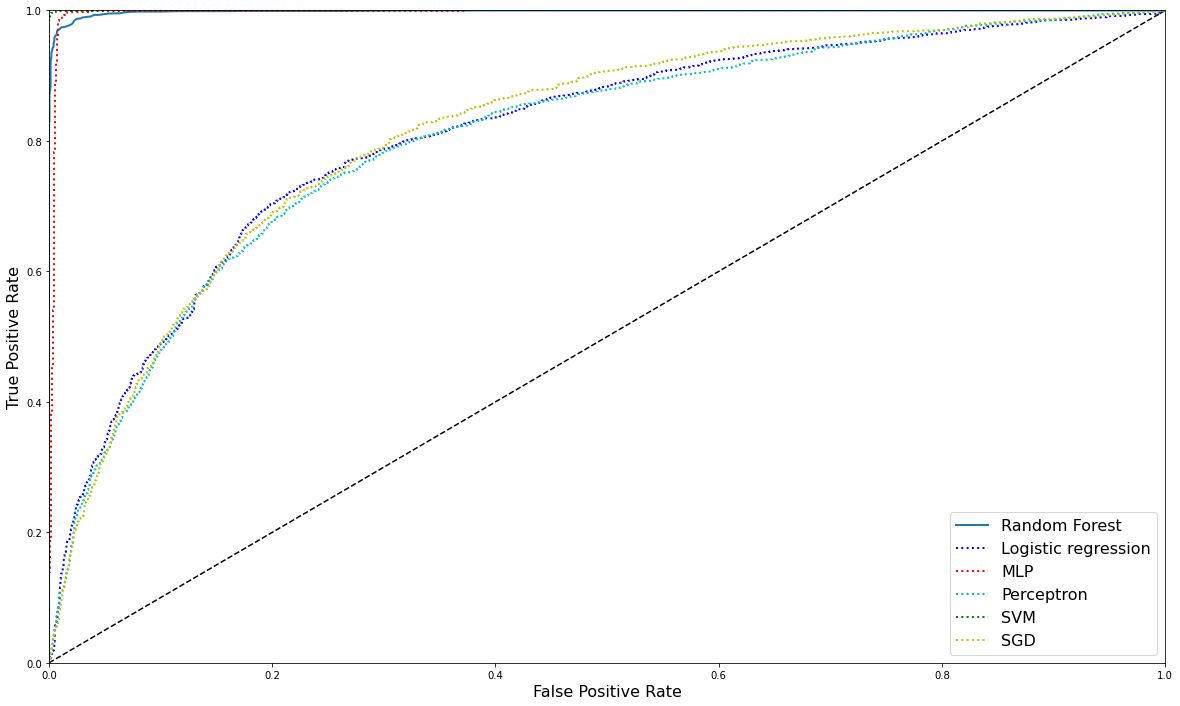

In [ ]:
plt.figure(figsize=(20,12))
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot(fpr_log, tpr_log, "b:", linewidth=2, label="Logistic regression")
plt.plot(fpr_mlpercept, tpr_mlpercept, "r:", linewidth=2, label="MLP")
plt.plot(fpr_percept, tpr_percept, "c:", linewidth=2, label="Perceptron")
plt.plot(fpr_svc, tpr_svc, 'g:', linewidth=2, label="SVM")
plt.plot(fpr_sgd, tpr_sgd, 'y:', linewidth=2, label="SGD")
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [ ]:
print('Modèle linéaire:')
print('Logistic',roc_auc_score(smote_data_y, y_predictions_log))
print('SGD', roc_auc_score(smote_data_y, y_predictions_sgd))
print('Perceptron', roc_auc_score(smote_data_y, y_predictions_percept))
print('-----------------------------')
print('Modèle non-linéaire:')
print('MLPerceptron', roc_auc_score(smote_data_y, y_predictions_mlpercept))
print('SVM', roc_auc_score(smote_data_y, y_predictions_svc))
print('Random Forest', roc_auc_score(smote_data_y, y_scores_forest))

Modèle linéaire:
Logistic 0.8105307754586296
SGD 0.816378647469806
Perceptron 0.8047659342583411
-----------------------------
Modèle non-linéaire:
MLPerceptron 0.9963735021881733
SVM 0.9999133690920121
Random Forest 0.9985969907302643


#Importance des features pour l'algorithme


In [ ]:
ada.fit(x_train_scaled, smote_data_y)
importances = ada.feature_importances_
std = np.std([tree.feature_importances_ for tree in ada.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Affiche le classement des features du forest
print("Classement des Features :")

#col = [x for x in x_train.columns]
sorts = [mf[x] for x in indices]
for f, c in zip(range(x_train_scaled.shape[1]), sorts):
    print("%d. feature %s (%f)" % (f + 1, c, importances[indices[f]]))

Classement des Features :
1. feature YearsAtCompany (0.105219)
2. feature MeanTimeAtWorkByYear (0.062711)
3. feature DistanceFromHome (0.048724)
4. feature MaritalStatus_Divorced (0.039734)
5. feature JobLevel (0.039080)
6. feature TrainingTimesLastYear (0.038938)
7. feature EnvironmentSatisfaction (0.038196)
8. feature EnvironmentSatisfaction (0.034574)
9. feature Education (0.031887)
10. feature MonthlyIncome (0.030918)
11. feature JobRole_Manufacturing Director (0.030891)
12. feature MaritalStatus_Married (0.029512)
13. feature WorkLifeBalance (0.029348)
14. feature JobRole_Healthcare Representative (0.028340)
15. feature NumCompaniesWorked (0.028292)
16. feature MeanTimeAtWorkByYear (0.026606)
17. feature Department_Human Resources (0.024614)
18. feature Education (0.024526)
19. feature JobRole_Manager (0.024359)
20. feature PerformanceRating (0.023828)
21. feature EducationField_Marketing (0.023782)
22. feature EducationField_Life Sciences (0.023519)
23. feature JobInvolvement (0.

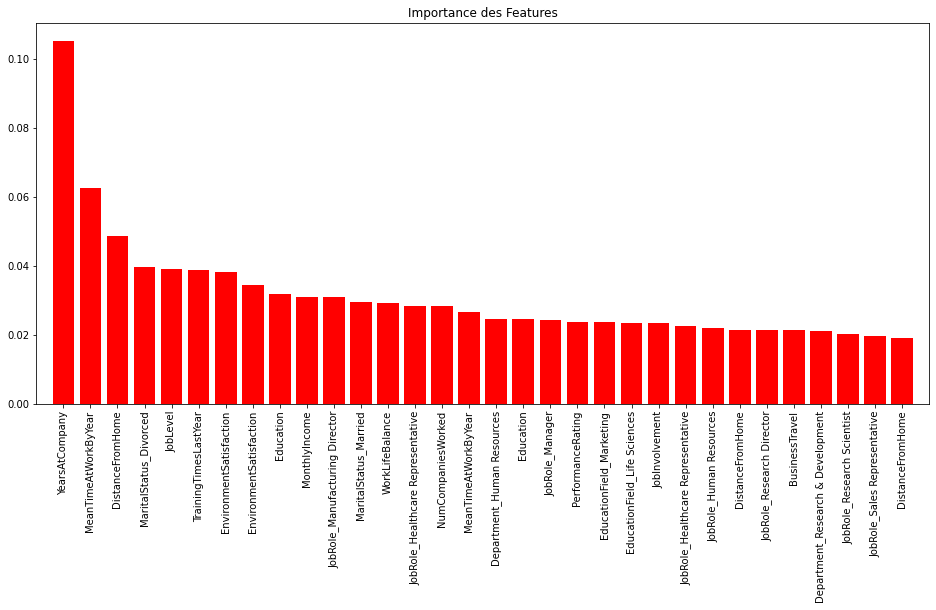

In [ ]:
plt.figure(figsize=(16,7))
plt.title("Importance des Features")
plt.bar(range(x_train_scaled.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(x_train_scaled.shape[1]), labels=sorts, rotation='vertical')
plt.xlim([-1, x_train_scaled.shape[1]])
plt.show()